# GP classification example with typical toy datasets

In [1]:
import math
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from collections import OrderedDict

from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Make the datasets

Moons               X : (100, 2) 	 y : (100,)
Circles             X : (100, 2) 	 y : (100,)
Gaussians           X : (300, 2) 	 y : (300,)


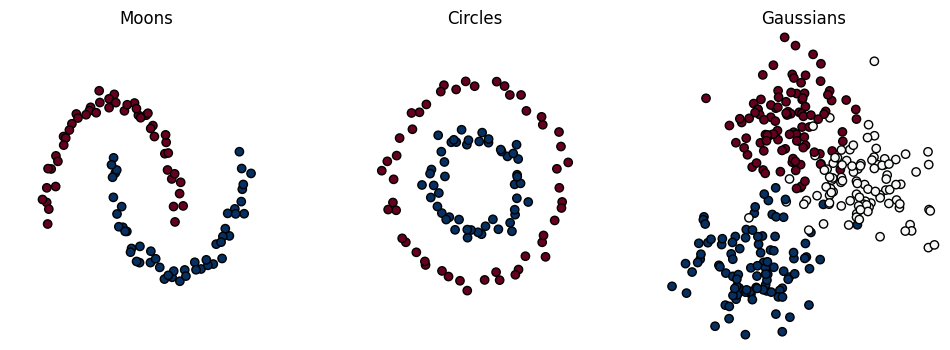

In [13]:
n_samples = 100
n_features = 2
noise = 0.05
random_state = 42

panel_width = 4
panel_height = 4

datasets = OrderedDict([('Moons', make_moons(n_samples=n_samples, noise=noise, random_state=random_state)),
                        ('Circles', make_circles(n_samples=n_samples, noise=noise, random_state=random_state, factor=0.5)),
                        # ('Gaussians', make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_features, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, random_state=random_state)),
                        ('Gaussians', make_blobs(n_samples=[n_samples, n_samples], n_features=n_features, centers=None, cluster_std=3.0, center_box=(-8.0, 8.0), shuffle=True, random_state=random_state, return_centers=False))
                        ]
                    )

fig = plt.figure(figsize=(panel_width*len(datasets), panel_height))

i = 1
for ds_name, ds in datasets.items():
    print(f'{ds_name:20}X : {ds[0].shape} \t y : {ds[1].shape}')

    x_min, x_max = ds[0][:,0].min() - 0.5, ds[0][:,0].max() + 0.5
    y_min, y_max = ds[0][:,1].min() - 0.5, ds[0][:,1].max() + 0.5

    ax = plt.subplot(1, len(datasets), i)

    # ax = sns.scatterplot(x=ds[0][:,0], y=ds[0][:,1], hue=ds[1])
    # ax.get_legend().set_visible(False)
    ax.scatter(ds[0][:,0], ds[0][:,1], c=ds[1], cmap=plt.cm.RdBu, edgecolors="k")

    ax.set_title(ds_name)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

    sns.despine(ax=ax, top=True, right=True, left=True, bottom=True, offset=10, trim=True)

    i = i + 1

plt.show()